# Bing Pilot Notebook
Purpose is to use Selenium to query names to test for ads via Bing.<br>
By: Jonathan Lo<br>
Date: 11/2/23

## Overhead

In [1]:
# Imports
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

from util import *

In [2]:
# Setup Webdriver Options
options = Options()

options.add_argument("--disable-notifications")
options.add_argument("--incognito")
options.add_experimental_option("prefs", {"plugins.plugins_list": [{"enabled": False, "name": "Chrome PDF Viewer"}]})
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features")
options.add_argument('--disable-extensions')
options.add_argument("--no-sandbox")

options.binary_location = "/usr/local/bin/webdriver"

In [3]:
# Setup Selenium
print("Internet connected: ", internet())
driver = webdriver.Chrome(options=options)

The chromedriver version (118.0.5993.70) detected in PATH at /usr/local/bin/chromedriver might not be compatible with the detected chrome version (119.0.6045.105); currently, chromedriver 119.0.6045.105 is recommended for chrome 119.*, so it is advised to delete the driver in PATH and retry


Internet connected:  True


## Collection

### Generating Names

In [4]:
# Init names
path = "./../data/pilot-names.json"
white_female_names = generate_names(path, 'white', 'female')
white_male_names = generate_names(path, 'white', 'male')
black_female_names = generate_names(path, 'black', 'female')
black_male_names = generate_names(path, 'black', 'male')

### Querying

'<html dir="ltr" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:web="http://schemas.live.com/Web/"><head><script type="text/javascript" nonce="">//<![CDATA[\nsi_ST=new Date\n//]]></script><!--pc--><title>Allison Smith public records - Search</title><meta content="text/html; charset=utf-8" http-equiv="content-type"><meta name="referrer" content="origin-when-cross-origin"><meta property="og:description" content="Intelligent search from Bing makes it easier to quickly find what you’re looking for and rewards you."><meta property="og:site_name" content="Bing"><meta property="og:title" content="Allison Smith public records - Bing"><meta property="og:url" content="https://www.bing.com/search?q=Allison Smith public records"><meta property="fb:app_id" content="570810223073062"><meta property="og:image" content="http://www.bing.com/sa/simg/facebook_sharing_5.png"><meta property="og:type" content="website"><meta property="og:image:width" content="600"><meta property="og:image
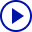
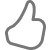
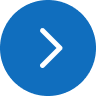
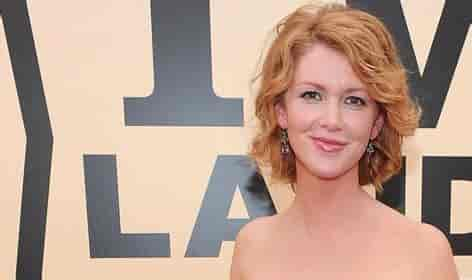
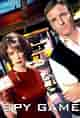
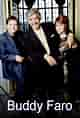
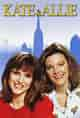
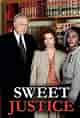
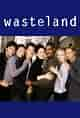
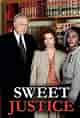
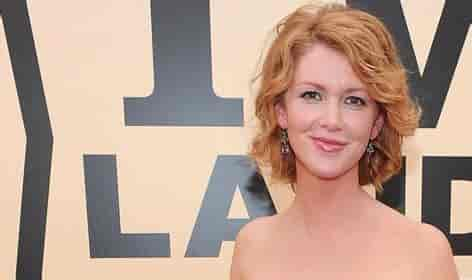
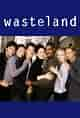
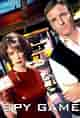
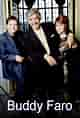
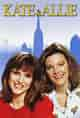

In [5]:
bing_search(f"{white_female_names[0]} public records", driver)